In [1]:
pip install cx_Oracle


Note: you may need to restart the kernel to use updated packages.


In [2]:
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
rc("font", family = "Malgun Gothic")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression



import warnings
warnings.filterwarnings("ignore")

In [4]:
def get_rmsle(model):
    pred = model.predict(X_test)
    pred = np.expm1(pred)  # 로그 역변환 (inverse log transformation)
    y_test_exp = np.expm1(y_test)  # 로그 역변환 (inverse log transformation)
    rmsle = np.sqrt(mean_squared_log_error(y_test_exp, pred))
    print(f"{model.__class__.__name__} RMSLE: {np.round(rmsle, 3)}")
    return rmsle

def get_rmsles(models):
    rmsles = []
    for model in models:
        rmsle = get_rmsle(model)
        rmsles.append(rmsle)
    return rmsles

In [6]:
traindata = pd.read_pickle("dataSet/traindata.pkl")
testdata = pd.read_pickle("dataSet/testdata.pkl")

FileNotFoundError: ignored

In [7]:
traindata

NameError: ignored

In [ ]:
testdata

,성별,연령대,거주지역,선호제휴점포,가공변화율,가공순증감률,신선변화율,신선순증감률,일상변화율,일상순증감률,...,명품변화율,명품순증감률,기타변화율,기타순증감률,종합변화율,종합순증감률,R rank,F rank,M rank,Label
0,F,노년층,부산,A29,11,1,1,-1,9,-1,...,4,-1,18,5,1,-1,1,4,8,173.76
1,F,노년층,서울,A2,16,4,7,4,16,7,...,2,0,18,5,3,1,9,4,10,114.58
2,F,노년층,서울,B7,7,2,9,2,18,-2,...,1,0,9,-4,7,1,5,8,5,65.52
3,F,노년층,서울,C195,11,3,10,3,16,-4,...,1,0,27,-2,6,0,1,7,2,180.39
4,F,노년층,서울,A20,10,3,17,-4,5,0,...,2,1,17,-4,6,2,1,3,9,99.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19378,F,청년층,서울,B27,0,0,5,2,3,2,...,1,0,7,0,12,8,1,2,8,319.37
19379,F,중년층,경북,C79,7,-5,5,-3,5,-2,...,1,0,6,-4,2,-2,1,10,3,44.12
19380,M,청년층,부산,C238,10,2,11,6,11,5,...,1,0,7,-2,7,5,1,8,6,77.59
19381,F,중년층,서울,C153,10,-3,3,1,5,-1,...,1,0,9,-2,3,-1,1,8,2,76.06


In [ ]:
traindata["Label"] = np.log1p(traindata["Label"])
testdata["Label"] = np.log1p(testdata["Label"])

In [ ]:
train_ohe = pd.get_dummies(traindata)
test_ohe = pd.get_dummies(testdata)

In [ ]:
y_train = train_ohe["Label"]
y_test = test_ohe["Label"]

X_train = train_ohe.drop(["Label"], axis = 1)
X_test = test_ohe.drop(["Label"], axis = 1)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

ridge = Ridge()
ridge.fit(X_train, y_train)

lasso = Lasso()
lasso.fit(X_train, y_train)

models = [lr, ridge, lasso]
get_rmsles(models)

LinearRegression RMSLE: 0.784
Ridge RMSLE: 0.781
Lasso RMSLE: 0.802


[0.7837897548890038, 0.7807578245227208, 0.8016386740843904]

In [ ]:
coef = pd.Series(lr.coef_, index = X_train.columns)
coef

가공변화율        0.002067
가공순증감률       0.020824
신선변화율        0.003430
신선순증감률       0.023862
일상변화율       -0.002208
               ...   
선호제휴점포_D5   -0.515829
선호제휴점포_D6   -0.688216
선호제휴점포_D7    0.130117
선호제휴점포_D8   -0.290951
선호제휴점포_D9    0.237242
Length: 722, dtype: float64

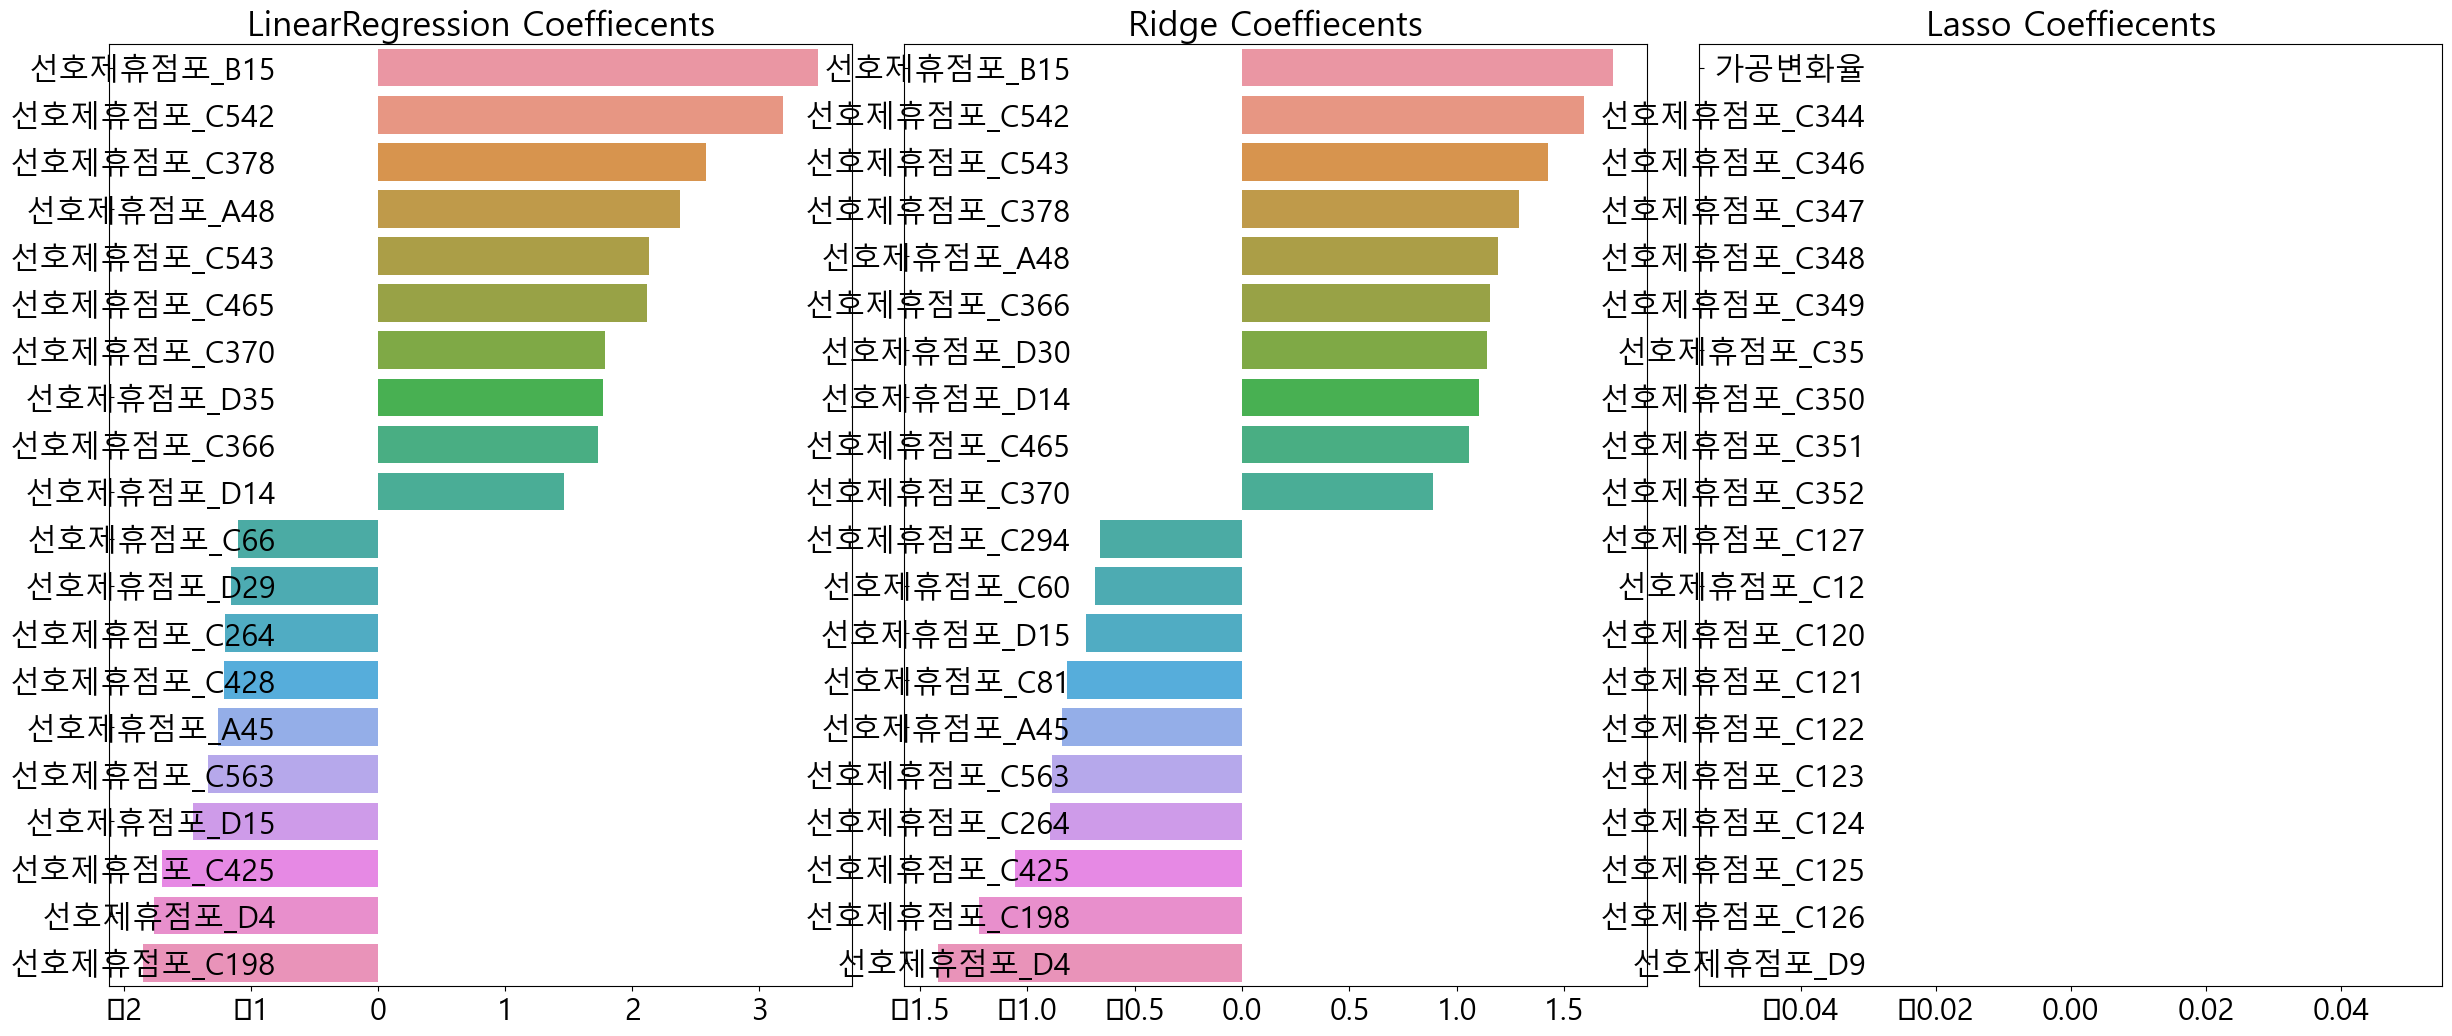

In [ ]:
def get_top_bottom_coef(model):
    coef = pd.Series(model.coef_, index = X_train.columns)

    coef_high = coef.sort_values(ascending = False).head(10)
    coef_low = coef.sort_values(ascending = False).tail(10)
    return coef_high, coef_low

def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout()
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화.
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합.
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.
models = [lr, ridge, lasso]
visualize_coefficient(models)

In [ ]:
def compare_arrays(arr1, arr2):
    count = 0
    for i in range(len(arr1)):
        if arr1[i] == arr2[i]:
            count += 1
    return count

def convert_values(arr):
    result = []
    for value in arr:
        if value < 85:
            result.append(3)
        elif value < 115:
            result.append(2)
        else:
            result.append(1)
    return result

def get_scores(arr1, arr2):
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(arr1)):
        if arr2[i] == 3 and arr1[i] == 3:
            TP += 1
        elif arr2[i] == 3 and arr1[i] != 3:
            FN += 1
        elif arr2[i] != 3 and arr1[i] != 3:
            TN += 1
        else:
            FP += 1
    print(f"[{TP}   {FP}]\n[{FN}   {TN}]")
    print(f"정밀도 : {round(TP/ (FP+TP)*100,2)}%")
    print(f"재현율 : {round(TP/ (FN+TP)*100,2)}%")
    print(f"정확도 : {round((TP+TN)/len(arr1)*100,2)}%")

In [ ]:
pre = np.expm1(ridge.predict(X_test))
real = np.array(np.expm1(y_test))
pre_cat = convert_values(pre)
real_cat = convert_values(real)
matching_count = compare_arrays(pre_cat, real_cat)
print(matching_count)
round(matching_count/len(pre)*100,2)

7577


40.16

In [ ]:
get_scores(pre_cat, real_cat)

[2211   2445]
[4639   9571]
정밀도 : 47.49%
재현율 : 32.28%
정확도 : 62.45%


In [ ]:
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid = params, scoring = "neg_mean_squared_error", cv = 5)
    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print("{0} 5 CV 시 최적 평균 RMSE 값 : {1}, 최적 alpha : {2}".format(model.__class__.__name__,
                                                                np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [ ]:
ridge_params = {"alpha" : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50]}
lasso_params = {"alpha" : [0.00001, 0.0001, 0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1.5, 10]}
best_ridge = print_best_params(ridge, ridge_params)
best_lasso = print_best_params(lasso, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.7077, 최적 alpha : {'alpha': 50}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.7085, 최적 alpha : {'alpha': 0.001}


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

ridge = Ridge(alpha = 50)
ridge.fit(X_train, y_train)

lasso = Lasso(alpha = 0.001)
lasso.fit(X_train, y_train)

models = [lr, ridge, lasso]
get_rmsles(models)

LinearRegression RMSLE: 0.784
Ridge RMSLE: 0.776
Lasso RMSLE: 0.775


[0.7837897548890038, 0.7761641871490369, 0.7752635841413529]

In [ ]:
pre = np.expm1(ridge.predict(X_test))
real = np.array(np.expm1(y_test))
pre_cat = convert_values(pre)
real_cat = convert_values(real)
matching_count = compare_arrays(pre_cat, real_cat)
print(matching_count)
round(matching_count/len(pre)*100,2)

7521


39.87

In [ ]:
get_scores(pre_cat, real_cat)

[2098   2301]
[4752   9715]
정밀도 : 47.69%
재현율 : 30.63%
정확도 : 62.62%
